#Просмотр данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Разархивируем zip файл - данные из kaggle
# Он изначально загружен на гугл диск
!unzip /content/drive/MyDrive/archive.zip -d /content/

Archive:  /content/drive/MyDrive/archive.zip
replace /content/HAM10000_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
metadata = pd.read_csv('/content/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Я не стану брать все столбики, только то, что необохдимо
metadata.drop(['lesion_id','dx_type','age','sex','localization'],axis = 1,inplace = True)
metadata.head(5)

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [ ]:
metadata.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

# Загрузка нейросети и настройка данных

In [ ]:
!pip install efficientnet-pytorch
!pip install --user torch==1.9.0 torchvision==0.10.0
!pip install fastai

In [ ]:
import fastai
import os
import cv2
from fastai.vision.all import *
from pathlib import Path
from efficientnet_pytorch import EfficientNet

In [ ]:
image_size = 32
path = '/content/Skin Cancer/Skin Cancer'

In [ ]:
# Создаем дата блоки, которые содержат фотографии и их id
# Значение Resize задает качество фотографий
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x= lambda x: path + "/" + x['image_id'] + ".jpg",
    get_y= lambda x: x['dx'],
    item_tfms = Resize(440),
    # batch_tfms = aug_transforms()
    batch_tfms = [*aug_transforms(size = 224, min_scale = 0.75)]
)

In [ ]:
dls = db.dataloaders(metadata, bs=32)

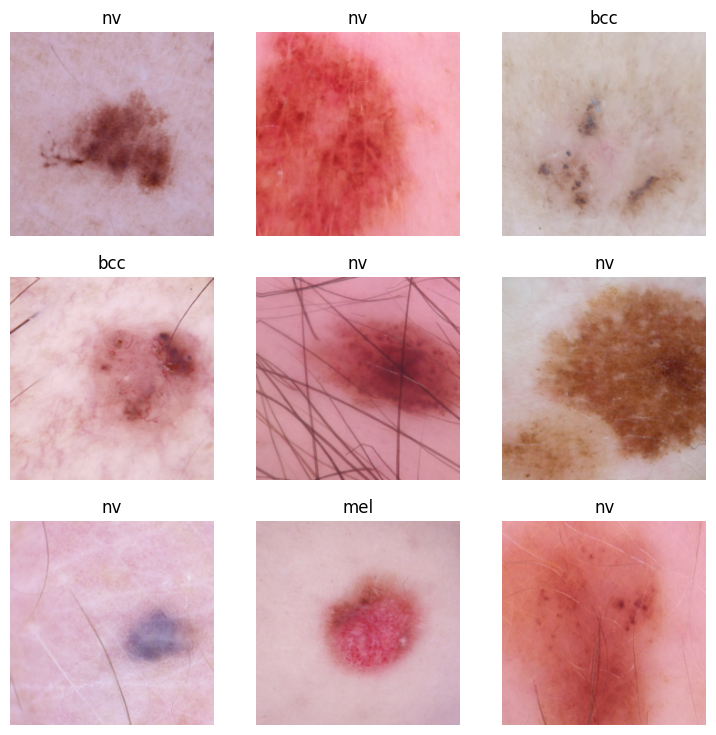

In [ ]:
dls.show_batch()

# Тренировка


In [ ]:
%%time
model = EfficientNet.from_name('efficientnet-b0')

CPU times: user 71.4 ms, sys: 550 µs, total: 71.9 ms
Wall time: 83 ms


In [ ]:
model._fc = nn.Linear(1280, dls.c)

In [ ]:
# MAP@5 Metric
def map_per_image(predictions, label):
    '''this function will calculate MAP@5 for a single image

    predictions = list of top 5 predictions for an image (Order does matter).
    label = true label
    '''
    try :
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError :
        return 0.0

def map_per_set(predictions, labels):
    '''this function calculates MAP@5 for the whole set

    predictions = list of list of all the predictions for every image.
    labels = list of true labels
    '''
    preds_sorted = []
    for i in predictions :
        temp = list(np.argsort(-i)[:5])
        preds_sorted.append(temp)
    return np.mean([map_per_image(p, l) for p,l in zip(preds_sorted, labels)])

In [ ]:
%%time
map5 = AccumMetric(map_per_set, to_np = False,  flatten = False)
learn = Learner(dls, model, metrics = [error_rate, map5, accuracy])

CPU times: user 1.43 ms, sys: 0 ns, total: 1.43 ms
Wall time: 1.44 ms


CPU times: user 10min 6s, sys: 1min 22s, total: 11min 28s
Wall time: 11min 49s


SuggestedLRs(valley=0.00013182566908653826)

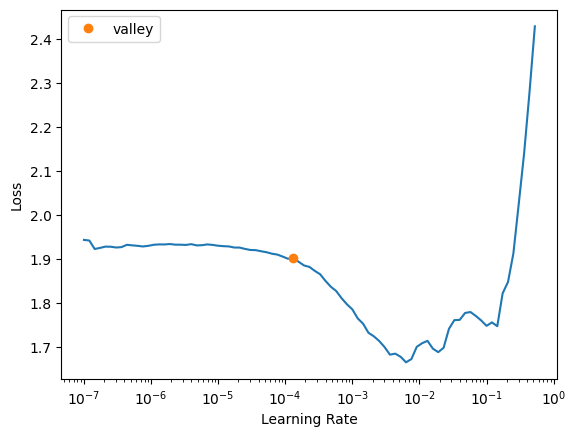

In [ ]:
# Поиск скорости обучения
%%time
learn.lr_find()

In [ ]:
%%time
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,map_per_set,accuracy,time
0,0.776359,0.713587,0.264104,0.838093,0.735896,31:52
1,0.772334,0.731192,0.269596,0.832476,0.730404,30:35
2,0.756111,0.718541,0.260609,0.838151,0.739391,30:32


epoch,train_loss,valid_loss,error_rate,map_per_set,accuracy,time
0,0.776359,0.713587,0.264104,0.838093,0.735896,31:52
1,0.772334,0.731192,0.269596,0.832476,0.730404,30:35
2,0.756111,0.718541,0.260609,0.838151,0.739391,30:32
3,0.717977,0.690327,0.258113,0.841147,0.741887,30:53
4,0.743326,0.683073,0.253120,0.844076,0.746880,30:56


CPU times: user 2h 10min 58s, sys: 20min 29s, total: 2h 31min 27s
Wall time: 2h 34min 50s


# Результат

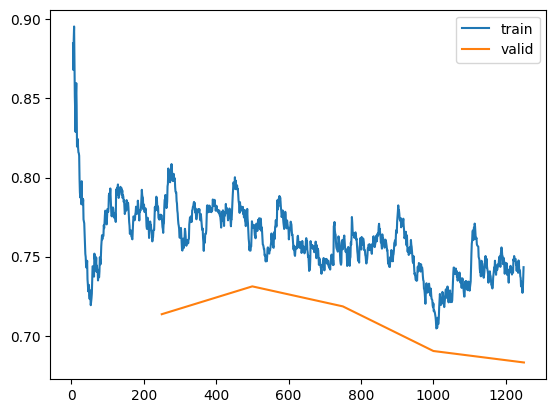

In [ ]:
learn.recorder.plot_loss()

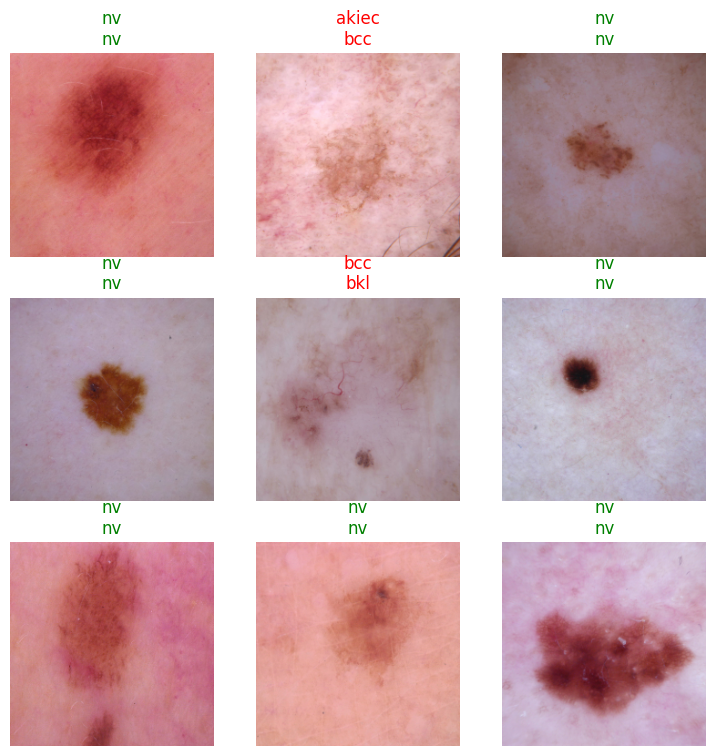

In [ ]:
learn.show_results()

In [ ]:
# Классификация изображения, которого не было в исходной выборке
learn.predict(item = 'путь к фотографии')

In [ ]:
# Сохранить модель
learn.export('Skin_Cancer_CNN.pth')

PicklingError: ignored

# Перевод в формат ONNX

In [ ]:
# Просмотр модели
learn.model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 49.3 MB/s eta 0:00:00


In [ ]:
torch.onnx.export(
    learn.model,
    torch.randn(1, 3, 224, 224),
    "Skin_Cancer.onnx",
    input_names=["image"],
    output_names=["Skin_Cancer"]
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

